In [10]:
import pandas as pd
import numpy as np

import random
import re
import io

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Seeding a pseudo-random number
np.random.seed(7)

## Load in isear in pickle format ##

In [35]:
isear = pd.read_pickle("isear.pkl")
isear.head()

,labels,texts
0,joy,days feel close partner friends feel peace als...
1,fear,every time imagine someone love could contact ...
2,anger,obviously unjustly treated possibility elucida...
3,sadness,think short time live relate periods life thin...
4,disgust,gathering found involuntarily sitting next two...


In [36]:
len(isear)

7516

## Map categorical labels to numerical labels ##

In [37]:
scale_mapper = {'anger':6, 
                'disgust':5,
                'fear':4,
                'guilt':3,
                'joy':2,
                'sadness':1,
                'shame':0}

isear['labels'].replace(scale_mapper, inplace=True)

labels = isear['labels'].tolist()
text = isear['texts'].values

In [38]:
print(len(labels))
print(len(text))

7516
7516


## Split data into training and test data, test data equal 15% ##

In [39]:
TEST_SPLIT = 0.15
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=TEST_SPLIT, random_state=42)

## Define pipelines for multinomial Naive Bayes and Support Vector Machine ##

In [17]:
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])

svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

models_1 = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ]

## 3-fold cross validation and calculate accuracy score

Observations:
1. All 4 models produces accuracy scores of less than 28%
2. Support Vector Machine using Countvectorizer produces the highest accuracy score

In [19]:
scores_1 = sorted([(name, cross_val_score(model, X_train, y_train, cv=3).mean()) 
                 for name, model in models_1])
print (tabulate(scores_1, floatfmt=".4f", headers=("model", 'score')))

model            score
-------------  -------
mult_nb         0.2619
mult_nb_tfidf   0.2473
svc             0.2704
svc_tfidf       0.2674


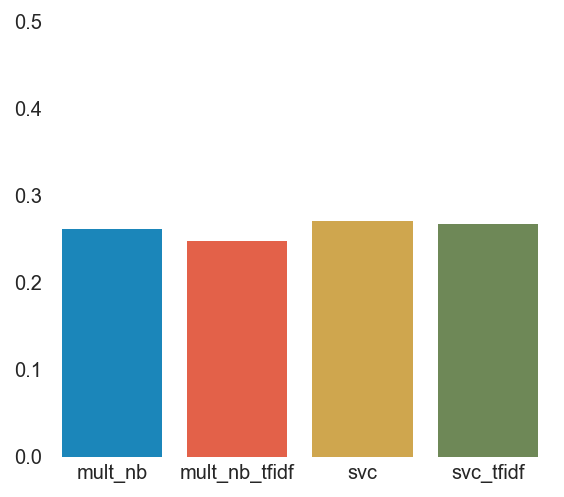

In [27]:
plt.style.use('fivethirtyeight')
sns.set_style('white')
%matplotlib inline
%config InlineBackend.figure_format ='retina'

plt.figure(figsize=(4, 4))
sns.barplot(x=[name for name, _ in scores_1], y=[score for _, score in scores_1])

plt.ylim(0,0.5)
plt.box(on=None)

### Choose SVC with countvectorizer and compare against testing data

In [28]:
scores = cross_val_score(svc, X_train, y_train, cv=3)
model = svc.fit(X_train,y_train)
predictions = model.predict(X_test)

In [29]:
print("Accuracy: %.3f")%(scores.mean())
print("Standard Deviation: %.3f")%(scores.std())
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.270
Standard Deviation: 0.012
Classification Report:
             precision    recall  f1-score   support

          0       0.22      0.13      0.17       166
          1       0.25      0.45      0.32       146
          2       0.35      0.37      0.36       182
          3       0.30      0.22      0.25       165
          4       0.24      0.30      0.26       143
          5       0.27      0.35      0.31       152
          6       0.29      0.12      0.17       174

avg / total       0.28      0.27      0.26      1128



In [30]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[22 38 28 14 25 30  9]
 [12 66 18  7 19 18  6]
 [ 9 50 68 16 13 19  7]
 [13 33 23 36 28 22 10]
 [16 23 20 13 43 20  8]
 [15 25 16 12 19 53 12]
 [11 29 23 23 35 32 21]]


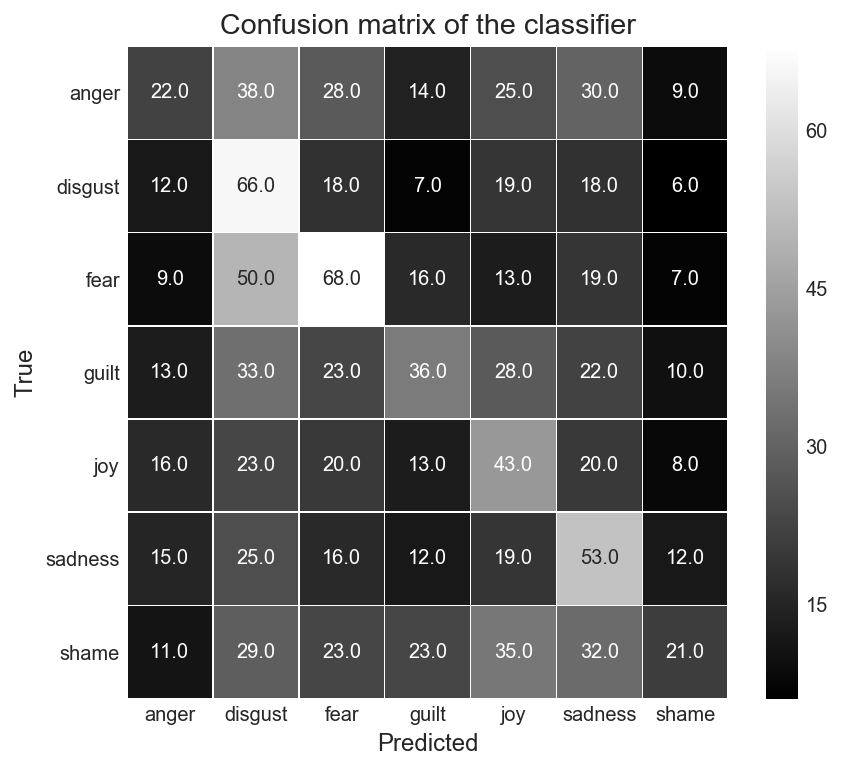

In [31]:
fig = plt.figure(figsize=(6,6))
labels = ['anger','disgust','fear','guilt','joy','sadness','shame']
ax= sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.3, square = False, cmap = plt.cm.gray);
plt.title('Confusion matrix of the classifier')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Conclusion

1. Both SVC and MultiNB are only able to produce accuracy scores of the most 27%
2. SVC with countvectorizer produced the best results
3. From the confustion matrix, the model has difficulty classifying anger and shame